# Inverting for the Source

The method uses observed data (processed according to FieldDataProcessing.ipynb)
and synthetic data (from SPECFEM3D) and applies a simple linear inversion formula:

\begin{equation}
S(\omega)^{*} = \frac{u^{t}d^{*}}{u^{t}u^{*}}
\end{equation}

where u is the simulated wavefield and d is the observed wavefield.

In [3]:
import obspy
import numpy as np
import pandas as pd
from myFormat.data_format import para_struct
from seisflows.tools.graphics import _convert_to_array
from scipy.interpolate import interp1d

## for ploting
import matplotlib.pyplot as plt 
from seisflows.tools.graphics import plot_section

import argparse


# for filtering
from obspy.signal.filter import bandpass


#### for spectrum plotting
from scipy import signal
#from obspy.signal.util import _npts2nfft
#from obspy.signal.invsim import cosine_sac_taper
from scipy.fftpack import fft, ifft, fftfreq

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from obspy import read, UTCDateTime
## for i/o
#from obspy import read
import scipy.io as sio 
from obspy.core.stream import Stream
import os  

flag_obs_type = 2 # 1 for su, 2 for matlab 

if flag_obs_type is 1: 
    stream_obs = read('obf/input/Up_delayed_ricker_f0500000.su',format='SU', byteorder='<')
    data_obs = _convert_to_array(stream_obs)
    
elif flag_obs_type is 2:
    from scipy.io import loadmat
    matfile2=loadmat('obf/input/Fan01_SRC08_mat.mat')
    data_obs = matfile2['fan_beam_scan_full']
    #type(data_obs)
print('the shape of the observed data: ', data_obs.shape)
    

stream_syn = read('obf/input/Up_Fan01_SRC08_sp2d.su',format='SU', byteorder='<')
data_syn = _convert_to_array(stream_syn)

trace_num = 90 

trace_obs = data_obs[:,trace_num]
print('shape of observed is :', trace_obs.shape)
trace_syn = data_syn[:,trace_num]
print('shape of synthetic signal is :', trace_syn.shape)



('the shape of the observed data: ', (3360, 179))
('shape of observed is :', (3360,))
('shape of synthetic signal is :', (28000,))


In [13]:
stf_syn_pd = pd.read_csv('obf/input/stf_gauss_f01000000',header=None,delim_whitespace=True)
stf_syn_1Dnp = stf_syn_pd.values
stf_syn = stf_syn_1Dnp[:,1]
stf_obs_1Dnp = pd.read_csv('obf/input/stf_delayed_ricker_f0500000',header=None,delim_whitespace=True).values
stf_obs = stf_obs_1Dnp[:,1]

syn_name = 'gaussian'
obs_name = 'ricker'

In [27]:
trace_obs.shape

(3360,)

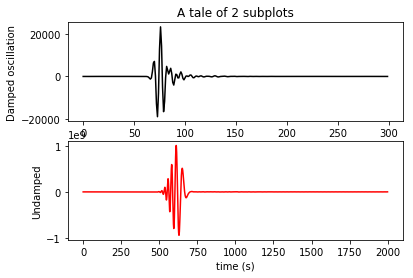

In [32]:
plt.subplot(2, 1, 1)
plt.plot(trace_obs[2500:2800], 'k-')
plt.title('A tale of 2 subplots')
plt.ylabel('Damped oscillation')

plt.subplot(2, 1, 2)
plt.plot(trace_syn[10000:12000], 'r-')
plt.xlabel('time (s)')
plt.ylabel('Undamped')

plt.show()

In [47]:
# create a class of structure that can be used to store parameters for 
from myFormat.data_format import para_struct
exp_para = para_struct('exp_para')
# load all parameters: 

f0=500000; exp_para.f0 = f0
fmax = 1000000; exp_para.fmax = fmax
#output_time_step = 20000; exp_para.output_time_step = output_time_step;
dt = 6e-9; exp_para.dt = dt
dtsyn = 6e-9; exp_para.dtsyn = dtsyn
dtobs = 5e-8; exp_para.dtobs = dtobs
#DownSampleFact=8; exp_para.DownSampleFact = DownSampleFact;
dtNew = dt; exp_para.dtNew = dtNew;

#%%% about the filters 
half_width=400000; exp_para.half_width = half_width;
low_freq=100000; exp_para.low_freq = low_freq;
high_freq=900000; exp_para.high_freq = high_freq;
band=[low_freq,high_freq]; exp_para.band = band;
nyq_freq=2.5e7; exp_para.nyq_freq = nyq_freq;
N=50000; exp_para.N = N;


In [48]:
#SOURCE_SIGNAL_MATRIX=para.SOURCE_SIGNAL_MATRIX;

##%%% 
#%rawdata = para.rawdata;
Nt=28000; exp_para.Nt = Nt; 
#Na=20250; exp_para.Na = Na; 
NSrc=1; exp_para.NSrc = NSrc; 
NRec=179; exp_para.NRec = NRec;

Ntsyn=28000; exp_para.Ntsyn = Ntsyn;
Ntobs=3360; exp_para.Ntobs = Ntobs; 

In [51]:
t_total = np.arange(dtNew,Nt*dtNew+dtNew,dtNew)
exp_para.t_total = t_total
t_total_syn = np.arange(dtsyn,Ntsyn*dtsyn+dtsyn,dtsyn)
exp_para.t_total_syn = t_total_syn
t_total_obs = np.arange(dtobs,Ntobs*dtobs+dtobs,dtobs)
exp_para.t_total_obs = t_total_obs

t_cut = t_total;exp_para.t_cut = t_cut


sample_total = np.arange(1,Nt+1,1)
sample_syn = np.arange(1,Ntsyn+1,1)
sample_obs = np.arange(1,Ntobs+1,1)
#sample_cut = np.arange(1,output_time_step+1,1)
#sample_cut  = sample_total

In [38]:
# load the received signal from the transducer

# t_total = np.arange(dtNew,Nt*dtNew+dtNew,dtNew)
# exp_para.t_total = t_total
# #t_cut = np.arange(dtNew,output_time_step*dtNew+dtNew,dtNew)
# #exp_para.t_cut = t_cut
# t_cut = t_total
# exp_para.t_cut = t_cut

# sample_total = np.arange(1,Nt+1,1)
# #sample_cut = np.arange(1,output_time_step+1,1)
# sample_cut  = sample_total

In [39]:
import pickle
pickle.dump(exp_para,open('obf/input/exp_para.pickle','wb'))


### 1.1 plot the received signals

ValueError: x and y must have same first dimension, but have shapes (28000,) and (1400,)

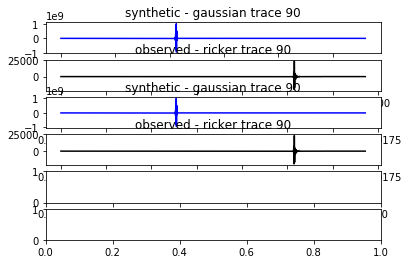

In [54]:
1.1 # plot the received signals
t_star_show = 0
t_end_show = Nt


fig, (ax0,ax1,ax2,ax3,ax4,ax5) = plt.subplots(nrows=6)

ax0.plot(sample_syn[t_star_show:t_end_show],trace_syn[t_star_show:t_end_show],'b-')
ax0.set_title('synthetic - ' + str(syn_name) + ' trace ' + str(trace_num))
ax0.set_xlabel('time steps')

ax1.plot(sample_obs[t_star_show:t_end_show],trace_obs[t_star_show:t_end_show],'k-')
ax1.set_title('observed - ' + str(obs_name) + ' trace ' + str(trace_num))
ax1.set_xlabel('time steps')

ax2.plot(t_total_syn[t_star_show:t_end_show],trace_syn[t_star_show:t_end_show],'b-')
ax2.set_title('synthetic - ' + str(syn_name) + ' trace ' + str(trace_num))
ax2.set_xlabel('time (s)')

ax3.plot(t_total_obs[t_star_show:t_end_show],trace_obs[t_star_show:t_end_show],'k-')
ax3.set_title('observed - ' + str(obs_name) + ' trace ' + str(trace_num))
ax3.set_xlabel('time (s)')

ax4.plot(t_total_syn[t_star_show:t_end_show],stf_syn[t_star_show:t_end_show],'b-')
ax4.set_title('synthetic - ' + str(syn_name) + ' trace ' + str(trace_num))
ax4.set_xlabel('time (s)')

ax5.plot(t_total_obs[t_star_show:t_end_show],stf_obs[t_star_show:t_end_show],'k-')
ax5.set_title('observed - ' + str(obs_name) + ' trace ' + str(trace_num))
ax5.set_xlabel('time (s)')

plt.tight_layout(rect=[0, 0, 1.5, 3])
fig.show()

### 1.2 zero padding for reliable FFT

In [9]:
import math as M
from future.utils import native
def next_pow_2(i):
    """
    Find the next power of two

    >>> int(next_pow_2(5))
    8
    >>> int(next_pow_2(250))
    256
    """
    # do not use NumPy here, math is much faster for single values
    buf = M.ceil(M.log(i) / M.log(2))
    return native(int(M.pow(2, buf)))

# signal filtering


fs=1./dt
print('original sampling frequency in experimental data (not used): %f Hz' % fs)
fs_new=1./dtNew
print('new sampling frequency after resampling: %f Hz' % fs_new)

nfft = next_pow_2(Nt)
print('zero-padded length of fft: %d ' % nfft)

#df_new = int(round(fs_new/nfft))
#print(df_new_round)
df_new = (fs_new/Nt)
df_new_pad = (fs_new/nfft)

print('frequency intervel before zero-padding: %f Hz ' % df_new)
print('frequency intervel after zero-padding: %f Hz (actually used)' % df_new_pad)


original sampling frequency in experimental data (not used): 25000000.000000 Hz
new sampling frequency after resampling: 25000000.000000 Hz
zero-padded length of fft: 2048 
frequency intervel before zero-padding: 17857.142857 Hz 
frequency intervel after zero-padding: 12207.031250 Hz (actually used)


### 1.3 calculate the frequency spectrum for original signals 

In [10]:
freq_show_star = 40000
freq_show_end = 10000000

freq_step_star = int(round(freq_show_star/df_new))
print(freq_step_star)
freq_step_end = int(round(freq_show_end/df_new))
print(freq_step_end)

xf = np.linspace(0.0, fs_new, nfft)
yf_obs = fft(trace_obs[0:Nt], axis=0, n=nfft)
yf_syn = fft(trace_syn[0:Nt], axis=0, n=nfft) 
yf_stf_obs = fft(stf_obs, axis=0, n=nfft)
yf_stf_syn = fft(stf_syn, axis=0, n=nfft) 



2
560


### 1.4 plot FFT results  

/home/jiazeh/Desktop/my_files/py2project/venv/lib/python2.7/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


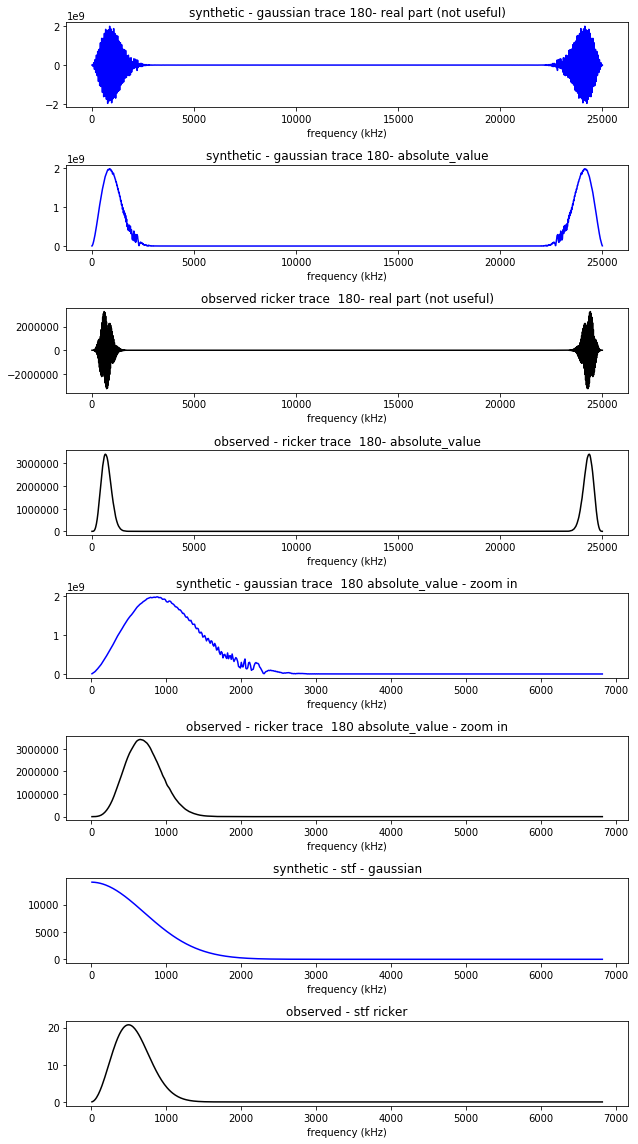

In [11]:
# sff - source frequency function 
fig, (ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7) = plt.subplots(nrows=8)
#ax0.set_title('synthetic - ' + str(syn_name) + ' trace ' + str(trace_num))
#ax1.set_title('observed - ' + str(obs_name) + ' trace ' + str(trace_num))
#ax0.subplot(2, 1, 2)
ax0.plot(xf/1000,yf_syn,'-b')
ax0.set_title('synthetic - ' + str(syn_name) + ' trace ' + str(trace_num) + '- real part (not useful)')
ax0.set_xlabel('frequency (kHz)')
#ax0.set_ylabel('received signals')

ax1.plot(xf/1000,np.abs(yf_syn),'-b')
ax1.set_title('synthetic - ' + str(syn_name) + ' trace ' + str(trace_num) + '- absolute_value')
ax1.set_xlabel('frequency (kHz)')

ax2.plot(xf/1000,yf_obs,'-k')
ax2.set_title('observed ' + str(obs_name) + ' trace  ' + str(trace_num) + '- real part (not useful)')
ax2.set_xlabel('frequency (kHz)')
#ax0.set_ylabel('received signals')

ax3.plot(xf/1000,np.abs(yf_obs),'-k')
ax3.set_title('observed - ' + str(obs_name) + ' trace  ' + str(trace_num) + '- absolute_value')
ax3.set_xlabel('frequency (kHz)')

ax4.plot(xf[freq_step_star-1:freq_step_end-1]/1000,np.abs(yf_syn[freq_step_star-1:freq_step_end-1]),'-b')
ax4.set_title( 'synthetic - ' + str(syn_name) + ' trace  ' + str(trace_num) + ' absolute_value - zoom in')
ax4.set_xlabel('frequency (kHz)')

ax5.plot(xf[freq_step_star-1:freq_step_end-1]/1000,np.abs(yf_obs[freq_step_star-1:freq_step_end-1]),'-k')
ax5.set_title( 'observed - ' + str(obs_name) + ' trace  ' + str(trace_num) + ' absolute_value - zoom in')
ax5.set_xlabel('frequency (kHz)')

ax6.plot(xf[freq_step_star-1:freq_step_end-1]/1000,np.abs(yf_stf_syn[freq_step_star-1:freq_step_end-1]),'-b')
ax6.set_title( 'synthetic - stf - ' + str(syn_name) )
ax6.set_xlabel('frequency (kHz)')

ax7.plot(xf[freq_step_star-1:freq_step_end-1]/1000,np.abs(yf_stf_obs[freq_step_star-1:freq_step_end-1]),'-k')
ax7.set_title( 'observed - stf ' + str(obs_name))
ax7.set_xlabel('frequency (kHz)')

plt.tight_layout(rect=[0, 0, 1.5, 4])

fig.show()

### 1.5 Try the bandpass function in obspy

### 1.6  We now generate the frequency filter that has already been applied ot the processed field data. We plot the filter to verify.

('tukey_length', 164)
('nfft', 2048)
('freq_pos.shape - tukey', (164,))
('freq_pos.shape - pad', (166,))
('freq_pos.shape - resize', (1024,))
('freq_neg.shape - freq_pos[::-1]', (1024,))
('syn_taper.shape - append', (2048,))


Text(0,0.5,'Gain')

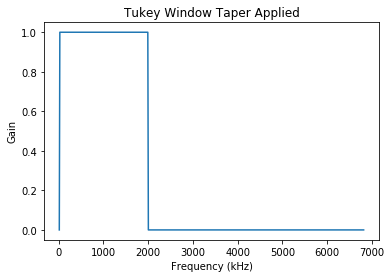

In [12]:
import numpy as np
from scipy import signal
from obspy.signal.util import _npts2nfft
from scipy.fftpack import fft, ifft, fftfreq

# Setup prefilter with cosine taper
#npts = len(field_trace.data) # resampled trace so different from FieldDataProcessing
#print('npts',npts)
#nfft = _npts2nfft(npts)

tukey_end_freq = 2000000
tukey_length = int(round(tukey_end_freq/df_new_pad))
print('tukey_length',tukey_length)

print('nfft',nfft)


freq_pos = signal.tukey(tukey_length, alpha=0.01)
print('freq_pos.shape - tukey',freq_pos.shape)
freq_pos = np.pad(freq_pos, 1,'constant',constant_values=0)
print('freq_pos.shape - pad',freq_pos.shape)
freq_pos.resize(nfft/2)
print('freq_pos.shape - resize',freq_pos.shape)
freq_neg = freq_pos[::-1]
print('freq_neg.shape - freq_pos[::-1]',freq_neg.shape)
syn_taper = np.append(freq_pos, freq_neg)
print('syn_taper.shape - append',syn_taper.shape)
syn_taper
# Plot the filter
freqs = fftfreq(nfft, d=dtNew)
#freqs = fftfreq(nfft, d=0.000000003)

#plt.plot(freqs[0:120]/1e3,freq_pos[0:120])
plt.plot(xf[freq_step_star-1:freq_step_end-1]/1e3,freq_pos[freq_step_star-1:freq_step_end-1])
plt.title('Tukey Window Taper Applied')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Gain')

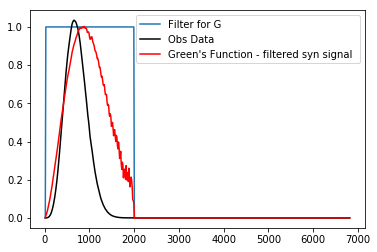

In [13]:
# Now we change into the frequency domain

yf_syn_maxnormed = yf_syn/max(yf_syn)
yf_obs_maxnormed = yf_obs/max(yf_obs)

#fftsyn = fft(syn_trace.data, n=nfft)
#fftfield = fft(field_trace.data, n=nfft)
yf_syn_filtered = yf_syn*syn_taper
yf_syn_filtered_maxnormed = yf_syn_filtered/max(yf_syn_filtered)

# Plot the spectrums
#plt.plot(freqs,syn_taper)
#plt.plot(freqs,np.abs(yf_syn_maxnormed),color="black")
#plt.plot(freqs,np.abs(yf_stf_obs_maxnormed),color="red")
plt.plot(xf[freq_step_star-1:freq_step_end-1]/1e3,syn_taper[freq_step_star-1:freq_step_end-1])
plt.plot(xf[freq_step_star-1:freq_step_end-1]/1e3,np.abs(yf_obs_maxnormed[freq_step_star-1:freq_step_end-1]),color="black")
plt.plot(xf[freq_step_star-1:freq_step_end-1]/1e3,np.abs(yf_syn_filtered_maxnormed[freq_step_star-1:freq_step_end-1]),color="red")


plt.legend(['Filter for G', 'Obs Data', "Green's Function - filtered syn signal "])

In [14]:
# Now we invert for the source in the frequency domain (obs as gaussian for Greens'function )
yf_stf_inverted = np.array([0.0+0.0j])
for i in range(1, nfft):
    if np.abs(yf_syn_filtered_maxnormed[i]) != 0:
        yf_stf_inverted = np.append(yf_stf_inverted, (yf_syn_filtered_maxnormed[i].T*yf_obs[i].conj().T)/(yf_syn_filtered_maxnormed[i].T*yf_syn_filtered_maxnormed[i].conj().T))
    else:
        yf_stf_inverted = np.append(yf_stf_inverted, 0.0+0.0j)
yf_stf_inverted = yf_stf_inverted.conj().T

In [15]:
#yf_stf_inverted = fft(stf_inverted[0:Nt], axis=0, n=nfft)
stf_inverted=ifft(yf_stf_inverted,n=nfft)

In [16]:
dtNew

4e-08

### 1.7 time shifted the inverted stf

In [17]:
from seisflows.plugins.misfit import Traveltime
time_step_comp = t_end_show
time_diff = Traveltime(stf_obs,stf_inverted,time_step_comp,dtNew)
print('difference in time in s:', time_diff)
time_delay = int(round(time_diff/dtNew))


('difference in time in s:', -1.2e-06)


In [18]:
a = np.zeros(np.abs(time_delay))
stf_inverted_shifted = np.append(a, stf_inverted[t_star_show:t_end_show+time_delay], axis=0)

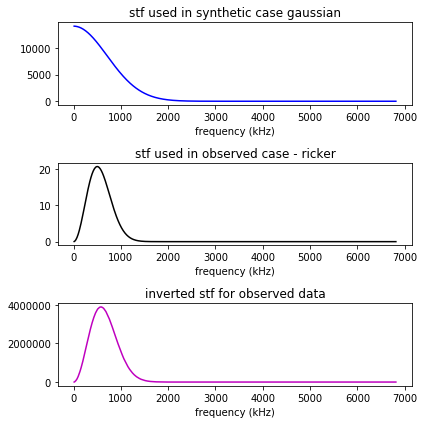

In [19]:
# sff - source frequency function 
fig, (ax0,ax1,ax2) = plt.subplots(nrows=3)

ax0.plot(xf[freq_step_star-1:freq_step_end-1]/1000,np.abs(yf_stf_syn[freq_step_star-1:freq_step_end-1]),'-b')
ax0.set_title( 'stf used in synthetic case ' + str(syn_name))
ax0.set_xlabel('frequency (kHz)')

ax1.plot(xf[freq_step_star-1:freq_step_end-1]/1000,np.abs(yf_stf_obs[freq_step_star-1:freq_step_end-1]),'-k')
ax1.set_title( 'stf used in observed case - ' + str(obs_name))
ax1.set_xlabel('frequency (kHz)')

ax2.plot(xf[freq_step_star-1:freq_step_end-1]/1000,np.abs(yf_stf_inverted[freq_step_star-1:freq_step_end-1]),'-m')
ax2.set_title( 'inverted stf for observed data')
ax2.set_xlabel('frequency (kHz)')

#ax1.plot(xf[freq_step_star-1:freq_step_end-1]/1000,np.abs(yf_stf_obs[freq_step_star-1:freq_step_end-1]),'-k')
#ax1.set_title( 'observed - gaussian, stf, absolute_value - zoom in')
#ax1.set_xlabel('frequency (kHz)')

plt.tight_layout(rect=[0, 0, 1, 1.5])

fig.show()

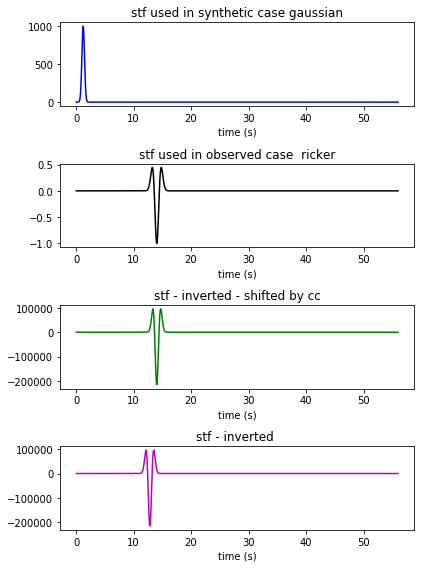

In [20]:
# stf - source time function 
fig, (ax0,ax1,ax2,ax3) = plt.subplots(nrows=4)

ax0.plot(t_total[t_star_show:t_end_show]*1e6,stf_syn[t_star_show:t_end_show],'b-')
ax0.set_title('stf used in synthetic case ' + str(syn_name))
ax0.set_xlabel('time (s)')

ax1.plot(t_total[t_star_show:t_end_show]*1e6,stf_obs[t_star_show:t_end_show],'k-')
ax1.set_title('stf used in observed case  ' + str(obs_name))
ax1.set_xlabel('time (s)')

ax2.plot(t_total[t_star_show:t_end_show]*1e6,stf_inverted_shifted[t_star_show:t_end_show],'g-')
ax2.set_title('stf - inverted - shifted by cc' )
ax2.set_xlabel('time (s)')


ax3.plot(t_total[t_star_show:t_end_show]*1e6,stf_inverted[t_star_show:t_end_show],'m-')
ax3.set_title('stf - inverted ')
ax3.set_xlabel('time (s)')

plt.tight_layout(rect=[0, 0, 1, 2])
fig.show()

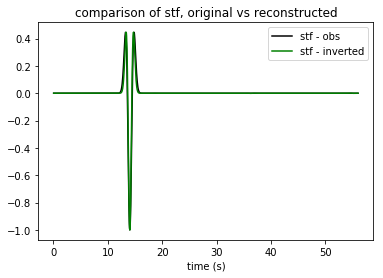

In [21]:
fig = plt.figure()
titlename = 'comparison of stf, original vs reconstructed'
num_rec = 2
ax = fig.add_subplot(1, 1, 1)
#ax = fig.add_subplot(num_rec, 1, i+1)
ax.plot(t_total[t_star_show:t_end_show]*1e6,stf_obs[t_star_show:t_end_show]/max(np.abs(stf_obs[t_star_show:t_end_show])),'k-',label='stf - obs')
ax.plot(t_total[t_star_show:t_end_show]*1e6,stf_inverted_shifted[t_star_show:t_end_show]/max(np.abs(stf_inverted_shifted[t_star_show:t_end_show])),'g-', label='stf - inverted')
#ax.set_title('stf - inverted - shifted by cc' )
ax.set_xlabel('time (s)')

ax.set_title(titlename)
ax.legend()    

### 1.8 post processing the inverted stf

In [22]:
# filtering 


freqmin=50000
freqmax=2600000

print(fs_new)

# filtering
#stf_filtered = bandpass(stf_cut_nodelay, freqmin, freqmax, fs_new, zerophase=True)
stf_inverted_shifted_filtered = bandpass(stf_inverted_shifted, freqmin, freqmax, fs_new, zerophase=True)
yf_stf_inverted_shifted_filtered = fft(stf_inverted_shifted_filtered, axis=0, n=nfft)

#stf_cut_nodelay_detrend = np.copy(signal.detrend(stf_inverted_shifted_filtered))
#yf_detrend = fft(stf_cut_nodelay_detrend, axis=0, n=nfft)
#stf_cut_nodelay_detrend_filtered = bandpass(stf_cut_nodelay_detrend, freqmin, freqmax, fs_new, zerophase=True)
#yf_detrend_filtered = fft(stf_cut_nodelay_detrend_filtered, axis=0, n=nfft) 

25000000.0


#### inverted stf

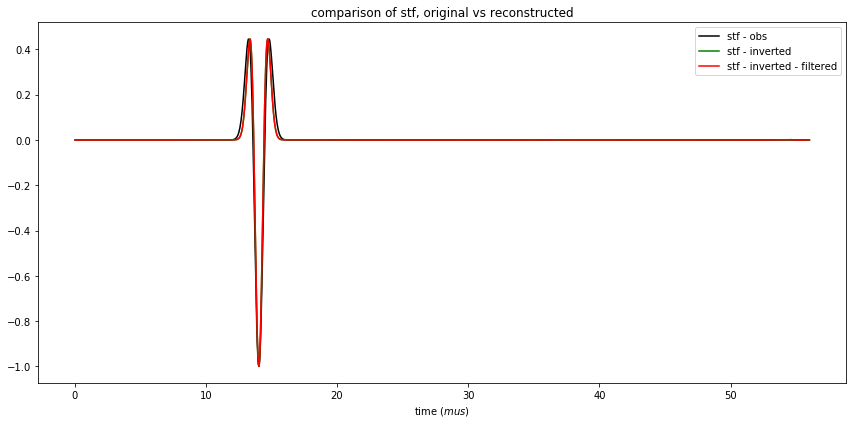

In [23]:
fig = plt.figure()
titlename = 'comparison of stf, original vs reconstructed'
num_rec = 2
ax = fig.add_subplot(1, 1, 1)
#ax = fig.add_subplot(num_rec, 1, i+1)
ax.plot(t_total[t_star_show:t_end_show]*1e6,stf_obs[t_star_show:t_end_show]/max(np.abs(stf_obs[t_star_show:t_end_show])),'k-',label='stf - obs')
ax.plot(t_total[t_star_show:t_end_show]*1e6,stf_inverted_shifted[t_star_show:t_end_show]/max(np.abs(stf_inverted_shifted[t_star_show:t_end_show])),'g-', label='stf - inverted')
ax.plot(t_total[t_star_show:t_end_show]*1e6,stf_inverted_shifted_filtered[t_star_show:t_end_show]/max(np.abs(stf_inverted_shifted[t_star_show:t_end_show])),'r-', label='stf - inverted - filtered')

#ax.set_title('stf - inverted - shifted by cc' )
ax.set_xlabel('time ($mus$)')

     
ax.set_title(titlename)
ax.legend()    

plt.tight_layout(rect=[0, 0, 2, 1.5])
fig.show()

### 1.9 save the signal as specfem's input

In [ ]:

import time
output_time_step = 1400

stf = open("obf/output/stf_inverted_ricker_1400","w")

for i in range(0,output_time_step):#nstep + delay):
    stf.write("%20.19f " %t_total[i])
    stf.write("%20.19f\n" %stf_inverted[i] )
    # to make sure the i/o is correct with the write function 
    #print(i)
    time.sleep(0.001)

### 2.0 ricker generation

In [24]:
import numpy as np
import matplotlib.pyplot as plt
 
def ricker(f, length=28e-6, dt=dtNew):
    t = np.arange(-length/2, (length-dt)/2, dt)
    y = - (1.0 - 2.0*(np.pi**2)*(f**2)*(t**2)) * np.exp(-(np.pi**2)*(f**2)*(t**2))
    return t, y
 
f = 500000 # A low wavelength of 25 Hz
t, w = ricker(f)


#time_delay = 500
#azeros = np.zeros(np.abs(time_delay))
#w_padded = np.append(azeros, w[t_star_show:t_end_show-time_delay], axis=0)



In [25]:
time_step_comp = t_end_show
time_diff =Traveltime(stf_inverted_shifted,w,time_step_comp,dtNew)
print('difference in time in s:', time_diff)
time_delay = int(round(time_diff/dtNew))
print('difference in timesteps :', time_delay)

('difference in time in s:', 0.0)
('difference in timesteps :', 0)


In [26]:
time_delay = 0
t_end_show = 7000
azeros = np.zeros(np.abs(time_delay))
w_padded = np.append(azeros, w[t_star_show:t_end_show-time_delay], axis=0)
w_padded2 = np.append(w_padded, np.zeros(t_end_show-len(t)), axis=0)

t_self = np.arange(dtNew,len(t)*dtNew+dtNew,dtNew)
t_self_long = np.arange(dtNew,t_end_show*dtNew,dtNew)

In [27]:
print('w_padded',w_padded.shape)
print('w_padded2',w_padded2.shape)
print('t_self',t_self.shape)
print('t_self_long',t_self_long.shape)


('w_padded', (700,))
('w_padded2', (7000,))
('t_self', (700,))
('t_self_long', (7000,))


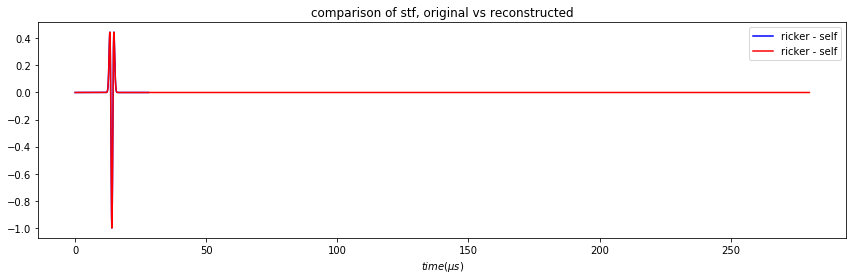

In [28]:
## unnormalized 
fig = plt.figure()
titlename = 'comparison of stf, original vs reconstructed'
num_rec = 2
ax = fig.add_subplot(1, 1, 1)
#ax = fig.add_subplot(num_rec, 1, i+1)
ax.plot(t_self*1e6,w_padded,'b-',label='ricker - self')
ax.plot(t_self_long*1e6,w_padded2,'r-',label='ricker - self')
#ax.plot(t_self*1e6,w_padded,'b-',label='ricker - self')
##ax.plot(t_self*1e6,w_padded2,'r-',label='ricker - self')
#ax.plot(t*1e6,w_padded2,'r-',label='ricker - self - backpadded')
###ax.plot(t_total[t_star_show:t_end_show]*1e6,stf_obs[t_star_show:t_end_show]/max(np.abs(stf_obs[t_star_show:t_end_show])),'k-',label='stf - obs')

#ax.plot(t_total[t_star_show:t_end_show]*1e6,stf_inverted_shifted[t_star_show:t_end_show]/max(np.abs(stf_inverted_shifted[t_star_show:t_end_show])),'g-', label='stf - inverted')
#ax.plot(t_total[t_star_show:t_end_show]*1e6,stf_inverted_shifted_filtered[t_star_show:t_end_show]/max(np.abs(stf_inverted_shifted[t_star_show:t_end_show])),'r-', label='stf - inverted - filtered')

#ax.set_title('stf - inverted - shifted by cc' )
###ax.set_xlabel(r'$time (\mus)$')
ax.set_xlabel(r'$ time (\mu s)$')

ax.set_title(titlename)
ax.legend()    

plt.tight_layout(rect=[0, 0, 2, 1])
fig.show()

In [ ]:
stf = open("obf/output/stf_ricker_small_delayed","w")


for i in range(0,7000):#nstep + delay):
    stf.write("%20.19f " %t_self_long[i])
    stf.write("%20.19f\n" %w_padded2[i] )
    # to make sure the i/o is correct with the write function 
    #print(i)
    time.sleep(0.001)

In [30]:
# # Setup prefilter with cosine taper
# #npts = len(syn_trace.data)
# #nfft = _npts2nfft(npts)
# freqindex = np.where(freqs>60)
# print(freqindex[0][0])
# freq_pos = signal.tukey(101, alpha=0.25)
# freq_pos = np.pad(freq_pos, 4,'constant',constant_values=0)
# freq_pos.resize(nfft/2)
# #freq_pos = np.roll(freq_pos, 4)
# freq_neg = freq_pos[::-1]
# freq_taper = np.append(freq_pos, freq_neg)

# # Plot the filter
# freqs = fftfreq(nfft, d=0.0003)
# # filter with cosine taper
# stf_inverted *= freq_taper
# #tf *= freq_taper
# #stf *= syn_taper
# plt.plot(ifft(stf_inverted,n=nfft)[0:Nt])
# plt.figure()
# plt.plot(freqs[0:100], np.abs(stf[0:100]))
# #plt.legend(['Taper Applied', 'STF after applying Taper'])

### 3.0 see the inverted source's output

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from obspy import read, UTCDateTime
## for i/o
#from obspy import read
import scipy.io as sio 
from obspy.core.stream import Stream
import os  
from seisflows.tools.graphics import _convert_to_array

Ntcomp=26000; #exp_para.Ntcomp = Ntcomp; 
dtNew = 6e-9;
t_src_comp = np.arange(dtNew,Ntcomp*dtNew+dtNew,dtNew)

stream_obs = read('obf/input/Up_Fan01_SRC08_sp2d.su',format='SU', byteorder='<')
data_obs = _convert_to_array(stream_obs)
print('the shape of the observed data: ', data_obs.shape)
stream_syn = read('obf/input/Up_tbd_81_96_f05000000.su',format='SU', byteorder='<')
data_syn = _convert_to_array(stream_syn)

trace_num = 83 

trace_obs = data_obs[:Ntcomp,trace_num]
print('shape of observed is :', trace_obs.shape)
trace_syn = data_syn[:Ntcomp,trace_num]
print('shape of inverted source signal is :', trace_syn.shape)



('the shape of the observed data: ', (28000, 176))
('shape of observed is :', (26000,))
('shape of inverted source signal is :', (26000,))


In [41]:
stf_syn_pd = pd.read_csv('obf/input/stf_inverted_ricker_f0500000',header=None,delim_whitespace=True)
stf_syn_1Dnp = stf_syn_pd.values
stf_syn = stf_syn_1Dnp[:,1]
stf_obs_1Dnp = pd.read_csv('obf/input/stf_delayed_ricker_f0500000',header=None,delim_whitespace=True).values
stf_obs = stf_obs_1Dnp[:,1]

syn_name = 'inverted'
obs_name = 'ricker'

In [42]:
#SOURCE_SIGNAL_MATRIX=para.SOURCE_SIGNAL_MATRIX;

##%%% 
#%rawdata = para.rawdata;

#Na=20250; exp_para.Na = Na; 
####NSrc=1; exp_para.NSrc = NSrc; 
####NRec=360; exp_para.NRec = NRec;
 

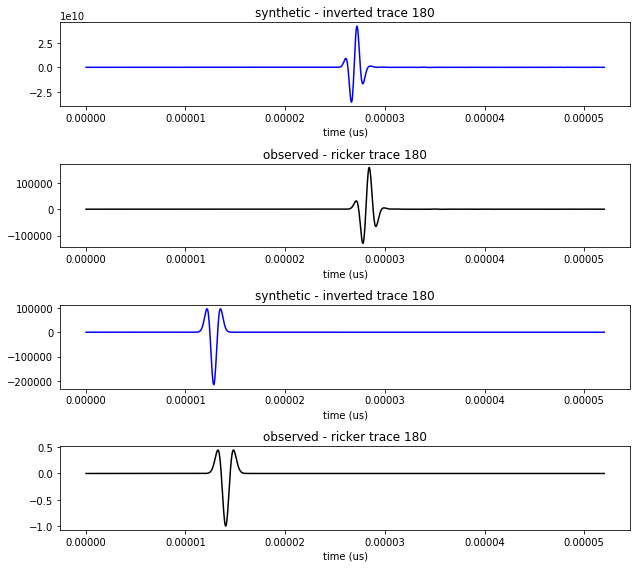

In [43]:
3.1 # plot the received signals from delay ricker with received signals from inverted src
t_star_show = 0
t_end_show = Ntcomp
t_total = t_src_comp
time_step_comp = t_end_show - t_star_show
fig, (ax2,ax3,ax4,ax5) = plt.subplots(nrows=4)

ax2.plot(t_total[t_star_show:t_end_show],trace_syn[t_star_show:t_end_show],'b-')
ax2.set_title('synthetic - ' + str(syn_name) + ' trace ' + str(trace_num))
ax2.set_xlabel('time (us)')

ax3.plot(t_total[t_star_show:t_end_show],trace_obs[t_star_show:t_end_show],'k-')
ax3.set_title('observed - ' + str(obs_name) + ' trace ' + str(trace_num))
ax3.set_xlabel('time (us)')

ax4.plot(t_total[t_star_show:t_end_show],stf_syn[t_star_show:t_end_show],'b-')
ax4.set_title('synthetic - ' + str(syn_name) + ' trace ' + str(trace_num))
ax4.set_xlabel('time (us)')

ax5.plot(t_total[t_star_show:t_end_show],stf_obs[t_star_show:t_end_show],'k-')
ax5.set_title('observed - ' + str(obs_name) + ' trace ' + str(trace_num))
ax5.set_xlabel('time (us)')

plt.tight_layout(rect=[0, 0, 1.5, 2])
fig.show()

In [44]:
### travel time 

from seisflows.plugins.misfit import Traveltime
time_step_comp = t_end_show
time_diff = Traveltime(trace_syn[t_star_show:t_end_show],trace_obs[t_star_show:t_end_show],time_step_comp,dtNew)
print('difference in time in s for regenerated inverted source:', time_diff)
time_delay = int(round(time_diff/dtNew))
time_delay

('difference in time in s for regenerated inverted source:', 1.2e-06)


30

In [45]:
a = np.zeros(np.abs(time_delay))
stf_inverted_shifted = np.append(a, stf_syn[t_star_show:t_end_show], axis=0)

### inverted and shifited stf

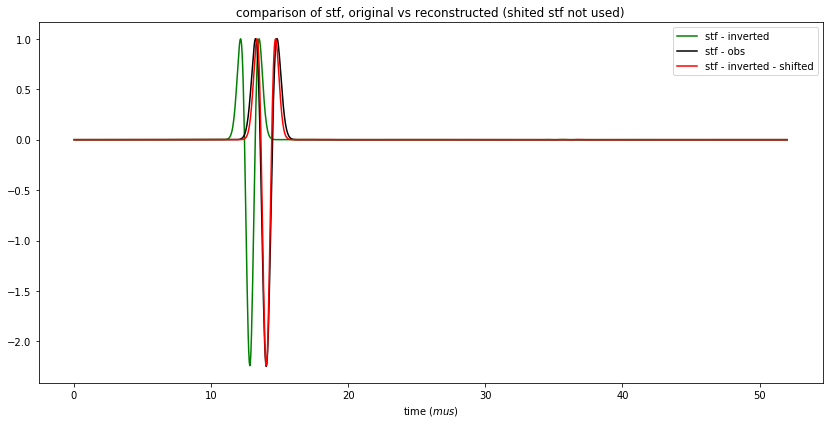

In [47]:
fig = plt.figure()
titlename = 'comparison of stf, original vs reconstructed (shited stf not used)'
num_rec = 2
ax = fig.add_subplot(1, 1, 1)
#ax = fig.add_subplot(num_rec, 1, i+1)
#ax.plot(t_total[t_star_show:t_end_show]*1e6,stf_obs[t_star_show:t_end_show]/max(np.abs(stf_obs[t_star_show:t_end_show])),'k-',label='stf - obs')
ax.plot(t_total[t_star_show:t_end_show]*1e6,stf_syn[t_star_show:t_end_show]/max(stf_syn[t_star_show:t_end_show]),'g-', label='stf - inverted')
ax.plot(t_total[t_star_show:t_end_show]*1e6,stf_obs[t_star_show:t_end_show]/max(stf_obs[t_star_show:t_end_show]),'k-', label='stf - obs')
ax.plot(t_total[t_star_show:t_end_show]*1e6,stf_inverted_shifted[t_star_show:t_end_show]/max(stf_inverted_shifted[t_star_show:t_end_show]),'r-', label='stf - inverted - shifted')

ax.set_xlabel('time ($mus$)')

     
ax.set_title(titlename)
ax.legend()    

plt.tight_layout(rect=[0, 0, 2, 1.5])
fig.show()

ratio_obs_over_invertetshifted = max(stf_obs[t_star_show:t_end_show])/max(stf_inverted_shifted[t_star_show:t_end_show])

In [48]:
ratio_obs_over_invertetshifted

4.616461537957489e-06

In [49]:
stf_inverted_shifted_ampadjusted = stf_inverted_shifted*ratio_obs_over_invertetshifted

In [52]:
import time

stf = open("obf/output/stf_ricker_inverted_shifted_ampadjusted","w")

for i in range(0,1300):#nstep + delay):
    stf.write("%20.19f " %t_src_comp[i])
    stf.write("%20.19f\n" %stf_inverted_shifted_ampadjusted[i] )
    # to make sure the i/o is correct with the write function 
    #print(i)
    time.sleep(0.001)

### 4.0 Final comparison see the inverted source's output vs obs data

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
from obspy import read, UTCDateTime
## for i/o
#from obspy import read
import scipy.io as sio 
from obspy.core.stream import Stream
import os  

Ntcomp=1300; exp_para.Ntcomp = Ntcomp; 

stream_obs = read('obf/input/Up_delayed_ricker_f0500000.su',format='SU', byteorder='<')
data_obs = _convert_to_array(stream_obs)
print('the shape of the observed data: ', data_obs.shape)
stream_syn = read('obf/input/Up_inverted_ricker_shifted_ampadjusted.su',format='SU', byteorder='<')
data_syn = _convert_to_array(stream_syn)

trace_num = 180 

trace_obs = data_obs[:Ntcomp,trace_num]
print('shape of observed is :', trace_obs.shape)
trace_syn = data_syn[:Ntcomp,trace_num]
print('shape of inverted source signal is :', trace_syn.shape)

stf_syn_pd = pd.read_csv('obf/input/stf_inverted_ricker_shifted_ampadjusted_f0500000',header=None,delim_whitespace=True)
stf_syn_1Dnp = stf_syn_pd.values
stf_syn = stf_syn_1Dnp[:,1]
stf_obs_1Dnp = pd.read_csv('obf/input/stf_delayed_ricker_f0500000',header=None,delim_whitespace=True).values
stf_obs = stf_obs_1Dnp[:,1]

syn_name = 'inverted shifted amplituded adjusted'
obs_name = 'ricker'

('the shape of the observed data: ', (1400, 360))
('shape of observed is :', (1300,))
('shape of inverted source signal is :', (1300,))


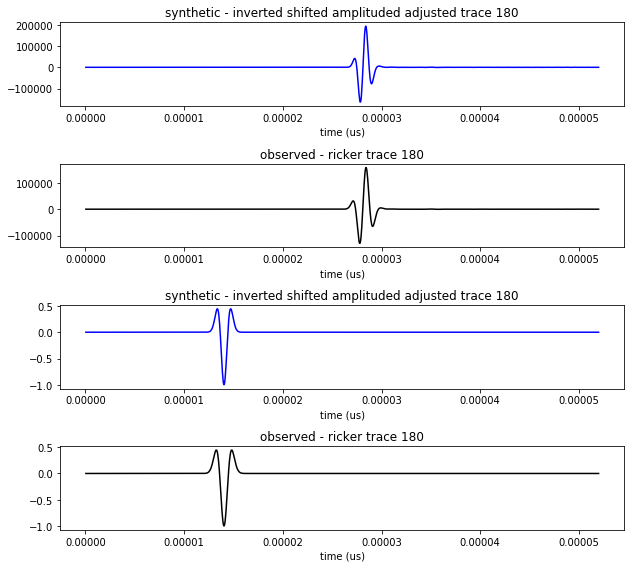

In [54]:
4.1 # plot the received signals from delay ricker with received signals from inverted src
t_star_show = 0
t_end_show = Ntcomp
t_total = t_src_comp
time_step_comp = t_end_show - t_star_show
fig, (ax2,ax3,ax4,ax5) = plt.subplots(nrows=4)

ax2.plot(t_total[t_star_show:t_end_show],trace_syn[t_star_show:t_end_show],'b-')
ax2.set_title('synthetic - ' + str(syn_name) + ' trace ' + str(trace_num))
ax2.set_xlabel('time (us)')

ax3.plot(t_total[t_star_show:t_end_show],trace_obs[t_star_show:t_end_show],'k-')
ax3.set_title('observed - ' + str(obs_name) + ' trace ' + str(trace_num))
ax3.set_xlabel('time (us)')

ax4.plot(t_total[t_star_show:t_end_show],stf_syn[t_star_show:t_end_show],'b-')
ax4.set_title('synthetic - ' + str(syn_name) + ' trace ' + str(trace_num))
ax4.set_xlabel('time (us)')

ax5.plot(t_total[t_star_show:t_end_show],stf_obs[t_star_show:t_end_show],'k-')
ax5.set_title('observed - ' + str(obs_name) + ' trace ' + str(trace_num))
ax5.set_xlabel('time (us)')

plt.tight_layout(rect=[0, 0, 1.5, 2])
fig.show()

In [55]:
mat_rec_plot=[180,40,80,120,160]
num_rec=len(mat_rec_plot)
flag_exp_data = 0
act_to_plot = 1
flag_seismotype = 4
time_step_star = 0
time_step_comp = 1300

/home/jiazeh/Desktop/my_files/py2project/venv/lib/python2.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.


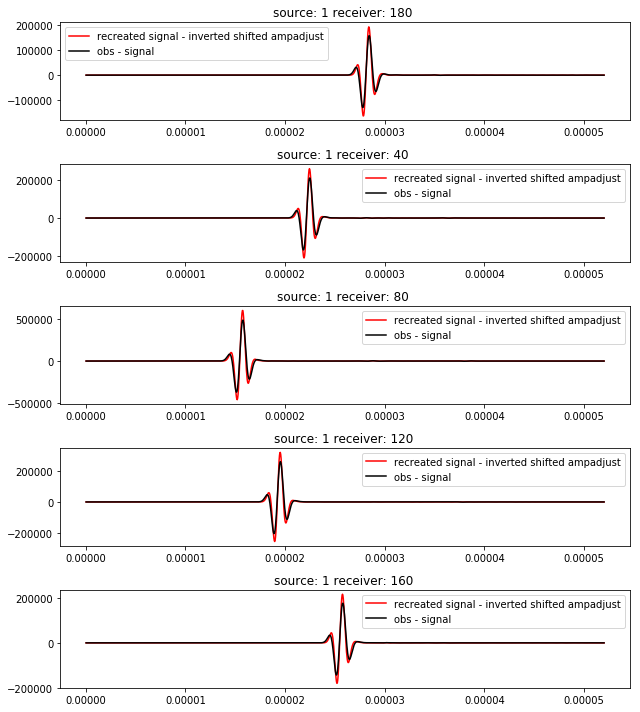

In [56]:

### subplot overlap - a few signal plots - multiple signal comparisons
fig = plt.figure()


for i in range(num_rec):
    col_num = mat_rec_plot[i]
    if (flag_exp_data is 1):  
        titlename = 'add delay steps %d source: %d receiver: %d ' % (time_delay,act_to_plot,col_num)
    else:
        titlename = 'source: %d receiver: %d ' % (act_to_plot,col_num)
    #fig, ax = plt.subplot(num_rec, 1, i+1)
    ax = fig.add_subplot(num_rec, 1, i+1) 
    if flag_seismotype != 4:
       ax.plot(t_cut[time_step_star:time_step_comp], Ux_data[time_step_star:time_step_comp,col_num], 'b-',label='Ux')
       ax.plot(t_cut[time_step_star:time_step_comp], Uz_data[time_step_star:time_step_comp,col_num], 'g-',label='Uz')
    ax.plot(t_total, data_syn[time_step_star:time_step_comp,col_num], 'r-',label='recreated signal - inverted shifted ampadjust')
    ax.plot(t_total, data_obs[time_step_star:time_step_comp,col_num], 'k-',label='obs - signal ')
        
    if (flag_exp_data is 1):  
        ax.plot(t_cut[time_step_star-time_delay:time_step_comp-time_delay], amp_factor*Ue_data[time_step_star:time_step_comp,col_num], 'r-',label='Ue')
    ax.hold(True)
    #fig.tight_layout()    
    plt.tight_layout(rect=[0, 0, 1.5, 2.5])
    ax.set_title(titlename)
    ax.legend()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from obspy import read, UTCDateTime

# First we read in the observed and synthetic data and plot a single trace
field_obs = read('observed', unpacked_headers=True) # processed field data (720 traces)
specfem3d_syn = read('synthetic', unpacked_headers= True) # Green's function from SPECFEM3D (720 traces)
field_trace = field_obs.traces[4] # Trace about ~10 m away from source
syn_trace = specfem3d_syn.traces[4] # Trace about ~10 m away from source
beginTime = UTCDateTime(syn_trace.stats.starttime)
syn_trace.trim(beginTime, beginTime+0.6)
syn_trace.detrend('constant')
syn_trace.taper(max_percentage=0.05,type='cosine')
syn_trace.plot()
beginTime = UTCDateTime(field_trace.stats.starttime)
field_trace.trim(beginTime, beginTime+0.6)
field_trace.detrend('constant')
field_trace.taper(max_percentage=0.05,type='cosine')
field_trace.plot()

In [ ]:
field_obs

In [ ]:
type(field_trace)

In [ ]:
beginTime_syn = UTCDateTime(syn_trace.stats.starttime)
beginTime_syn

In [ ]:
beginTime_obs = UTCDateTime(syn_trace.stats.starttime)
beginTime_obs

We now generate the frequency filter that has already been applied ot the processed field data. We plot the filter to verify.

In [ ]:
import numpy as np
from scipy import signal
from obspy.signal.util import _npts2nfft
from scipy.fftpack import fft, ifft, fftfreq

# Setup prefilter with cosine taper
npts = len(field_trace.data) # resampled trace so different from FieldDataProcessing
nfft = _npts2nfft(npts)
freq_pos = signal.tukey(101, alpha=0.25)
#print('freq_pos',freq_pos)
freq_pos = np.pad(freq_pos, 4,'constant',constant_values=0)
freq_pos.resize(nfft/2)
freq_neg = freq_pos[::-1]
syn_taper = np.append(freq_pos, freq_neg)
syn_taper
# Plot the filter
freqs = fftfreq(nfft, d=0.0003)
plt.plot(freqs[0:120],freq_pos[0:120])
plt.title('Tukey Window Taper Applied')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')

In [ ]:
# Now we change into the frequency domain
syn_trace.data /= max(syn_trace.data)

fftsyn = fft(syn_trace.data, n=nfft)
fftfield = fft(field_trace.data, n=nfft)
fftsyn *= syn_taper

# Plot the spectrums
plt.plot(freqs,syn_taper)
plt.plot(freqs,np.abs(fftfield),color="black")
plt.plot(freqs,np.abs(fftsyn),color="red")
plt.legend(['Filter for G', 'Field Data', "Green's Function"])

In [ ]:
# Now we invert for the source in the frequency domain 
stf = np.array([0.0+0.0j])
for i in range(1, nfft):
    if np.abs(fftsyn[i]) != 0:
        stf = np.append(stf, (fftsyn[i].T*fftfield[i].conj().T)/(fftsyn[i].T*fftsyn[i].conj().T))
    else:
        stf = np.append(stf, 0.0+0.0j)
stf = stf.conj().T

In [ ]:
# Setup prefilter with cosine taper
#npts = len(syn_trace.data)
#nfft = _npts2nfft(npts)
freqindex = np.where(freqs>60)
print(freqindex[0][0])
freq_pos = signal.tukey(101, alpha=0.25)
freq_pos = np.pad(freq_pos, 4,'constant',constant_values=0)
freq_pos.resize(nfft/2)
#freq_pos = np.roll(freq_pos, 4)
freq_neg = freq_pos[::-1]
freq_taper = np.append(freq_pos, freq_neg)
# Plot the filter
freqs = fftfreq(nfft, d=0.0003)
# filter with cosine taper
stf *= freq_taper
#tf *= freq_taper
#stf *= syn_taper
plt.plot(ifft(stf,n=nfft)[0:npts])
plt.figure()
plt.plot(freqs[0:100], np.abs(stf[0:100]))
#plt.legend(['Taper Applied', 'STF after applying Taper'])

In [ ]:
from obspy import Trace
st = Trace(data=ifft(stf,n=nfft)[0:npts])
st.stats.delta=0.0003
st.taper(max_percentage=0.05,type='hann')
st.filter('bandpass',freqmin=8,freqmax=20,zerophase=True)
plt.plot(st)
plt.figure()
plt.plot(freqs[0:100], np.abs(stf[0:100]))

In [ ]:
# Now convolve the source with the Green's Function
from obspy.core import Trace
from numpy.fft import *
#ik = np.array([2j*np.pi*k for k in xrange(0, nfft)])/ nfft
#fshift = np.exp(-ik*52)
syn_trace = specfem3d_syn.traces[4] # Trace about ~10 m away from source
beginTime = UTCDateTime(syn_trace.stats.starttime)
syn_trace.trim(beginTime, beginTime+0.6)
syn_trace.detrend('constant')
syn_trace.taper(max_percentage=0.05,type='cosine')
w = np.linalg.norm(syn_trace.data, ord=2)
syn_trace.data /= w
fftsyn = fft(syn_trace.data, n=nfft)
fftsyn *= syn_taper
#stf *= syn_taper
st = Trace(data=ifft(stf,n=nfft)[0:npts])
st.stats.delta=0.0003
st.detrend('demean')
st.taper(max_percentage=0.05,type='hann')
st.filter('bandpass',freqmin=8,freqmax=20,zerophase=True)
convolved_Green=ifft(fftsyn*fft(st.data,n=nfft), n=nfft)[0:npts]
synGreen = Trace(data=convolved_Green)
synGreen.stats.delta=0.0003
#plt.plot(ifft(stf,n=nfft)[0:npts])
synGreen.filter('bandpass',freqmin=8,freqmax=20,zerophase=True)
w = np.linalg.norm(synGreen.data, ord=2)
synGreen.data /= w
plt.plot(synGreen, color="red")
field_trace = field_obs.traces[4] # Trace about ~10 m away from source
field_trace.filter('bandpass',freqmin=8,freqmax=20,zerophase=True)
w = np.linalg.norm(field_trace.data, ord=2)
field_trace.data /= w
plt.plot(field_trace, color="black")
syn_trace.filter('bandpass',freqmin=8,freqmax=20,zerophase=True)
w = np.linalg.norm(syn_trace.data, ord=2)
syn_trace.data /= w
plt.plot(syn_trace,color="green")
plt.legend(["Green's function convolved with STF", "Field Data", "Green's function"])
plt.savefig('compare.pdf')

# Robust Source Inversion

This notebook improves the method described in SourceInversionSteps.ipynb by stacking
the results from the formula using different traces in a small radius from the source.

In [ ]:
%matplotlib inline
import numpy as np
from obspy.core import Stream, Trace
from obspy.signal.util import _npts2nfft
from scipy import signal
from scipy.fftpack import fft, ifft, fftfreq
import matplotlib.pyplot as plt
from obspy import read, UTCDateTime

# First we read in the observed and synthetic data
field_obs = read('processed_obsIR.su', unpacked_headers=True) # processed field data (720 traces)
specfem3d_syn = read('0_dz_SU', unpacked_headers= True) # Green's function from SPECFEM3D (720 traces)

In [ ]:
allstf = np.zeros(1, dtype=np.complex)# Used to store the stacked stf
print(allstf.shape)
num_traces = 5 # number of traces used to estimate STF
#wshift = np.arange(0,0.0015,.0003) # shifting windows
    
for trace_index in range(0, num_traces): # Each trace is used to estimate STF 
    print(allstf.shape)

    field_trace = field_obs.traces[trace_index]
    syn_trace = specfem3d_syn.traces[trace_index]
    
    # Cut the window around the direct arrival
    beginTime = UTCDateTime(field_trace.stats.starttime)
    field_trace.trim(beginTime, beginTime+0.6)
    beginTime = UTCDateTime(syn_trace.stats.starttime)
    syn_trace.trim(beginTime, beginTime+0.6)

    field_trace.detrend('constant')
    field_trace.taper(max_percentage=0.05,type='cosine')

    syn_trace.detrend('constant')
    syn_trace.taper(max_percentage=0.05,type='cosine')
    # Now we change into the frequency domain
    if (trace_index == 0): # First trace
        npts = len(field_trace.data) # length of signal
        nfft = _npts2nfft(npts)
        allstf.resize(nfft)
    print(allstf.shape)

    syn_trace.normalize() # FIX! This should not be necessary
    fftsyn = fft(syn_trace.data, n=nfft)
    fftfield = fft(field_trace.data, n=nfft)
    freqs = fftfreq(len(fftfield), d=0.0003)

    # Setup prefilter with cosine taper
    freqindex = np.where(freqs>85)
    freq_pos = signal.tukey(101, alpha=0.25)
    freq_pos.resize(nfft/2)
    freq_neg = freq_pos[::-1]
    freq_taper = np.append(freq_pos, freq_neg)

    # Apply prefilter to synthetic (already applied to real data)
    fftsyn *= freq_taper
        
    # Now we invert for the source in the frequency domain 
    stf = np.array([0.0+0.0j])
    for i in range(1, nfft):
        if np.abs(fftsyn[i]) != 0:
            stf = np.append(stf, (fftsyn[i].T*fftfield[i].conj().T)/(fftsyn[i].T*fftsyn[i].conj().T))
        else:
            stf = np.append(stf, 0.0+0.0j)
    stf = stf.conj().T
    plt.plot(freqs[0:50], np.abs(stf[0:50]))
    stf *= freq_taper # filter the stf
    print(allstf.shape,stf.shape)
    allstf += stf # stack the stf
plt.legend(['trace 1', 'trace 2', 'trace 3', 'trace 4', 'trace 5'])
allstf /= num_traces # Normalize

In [ ]:
# Now convolve the source with the Green's Function
from obspy.core import Trace
convolved_Green=ifft(fftsyn*allstf, n=nfft)[0:npts]
synGreen = Trace(data=convolved_Green)
synGreen.stats.delta=0.0003
plt.plot(synGreen.data, color="red")
plt.plot(ifft(fftfield, n=nfft)[0:npts], color="black")
plt.legend(["Green's function convolved with STF", "Field Data"])